**Project Proposal**

**Introduction**

In the United States, 48% of the population lives with heart disease. Notably, the vast majority of individuals live with a significant risk factor for heart disease.   

This project will answer the question: 

*“How accurately could predictors in the Cleveland Heart Disease Data Set predict the presence of heart disease in an individual?”*     

Our dataset originates from the V.A. Medical Center, Long Beach and Cleveland Clinic Foundation. 


**Exploratory Analysis**

In [1]:
# First we load in the packages that will need to later use.
library(repr)
library(tidyverse)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6, repr.plot.width = 12, repr.plot.height = 10)

── Attaching core tidyverse packages ───────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ─────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ─────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ─────────────────────────────────────

In [2]:
# We read the raw heart disease data from the web.
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), 
                       col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
                                     "slope", "ca", "thal", "num"))
heart_data

Rows: 303 Columns: 14
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Now we select the columns that we may potentially use as predictors for our classification model. We mutate all cases where num > 0 to 1 as we simply want to determine if the patient has heart disease and not what stage of heart disease it is.

In [3]:
heart_selected <- select(heart_data, age, trestbps, chol, thalach, oldpeak, num) |>
    mutate(num = as_factor(case_when(num > 0 ~ 1, num == 0 ~ 0)))
heart_selected

age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,0
67,160,286,108,1.5,1
67,120,229,129,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1.2,1
57,130,236,174,0.0,1
38,138,175,173,0.0,0


**Each column represents the following:**

age - in years    
trestbps - the resting blood pressure in mm Hg (unit of pressure)  
chol - serum cholesterol (mg/dl)  
thalach - maximum heart rate achieved  
oldpeak - ST depression induced by exercise relative to rest  
num - presence of heart disease    

In [4]:
# Splitting training and testing data.
heart_split <- initial_split(heart_selected, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Table showing the number of observations and mean values of each class.

In [5]:
heart_sum <- heart_train |> 
    group_by(num) |> 
    summarize(count = n(), mean_age = mean(age), mean_trestbps = mean(trestbps), 
              mean_chol = mean(chol), mean_thalach = mean(thalach), mean_oldpeak = mean(oldpeak))
heart_sum

num,count,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,123,52.56098,128.5122,242.7886,158.2764,0.6065041
1,104,56.91346,135.0769,250.7885,139.0096,1.5153846


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


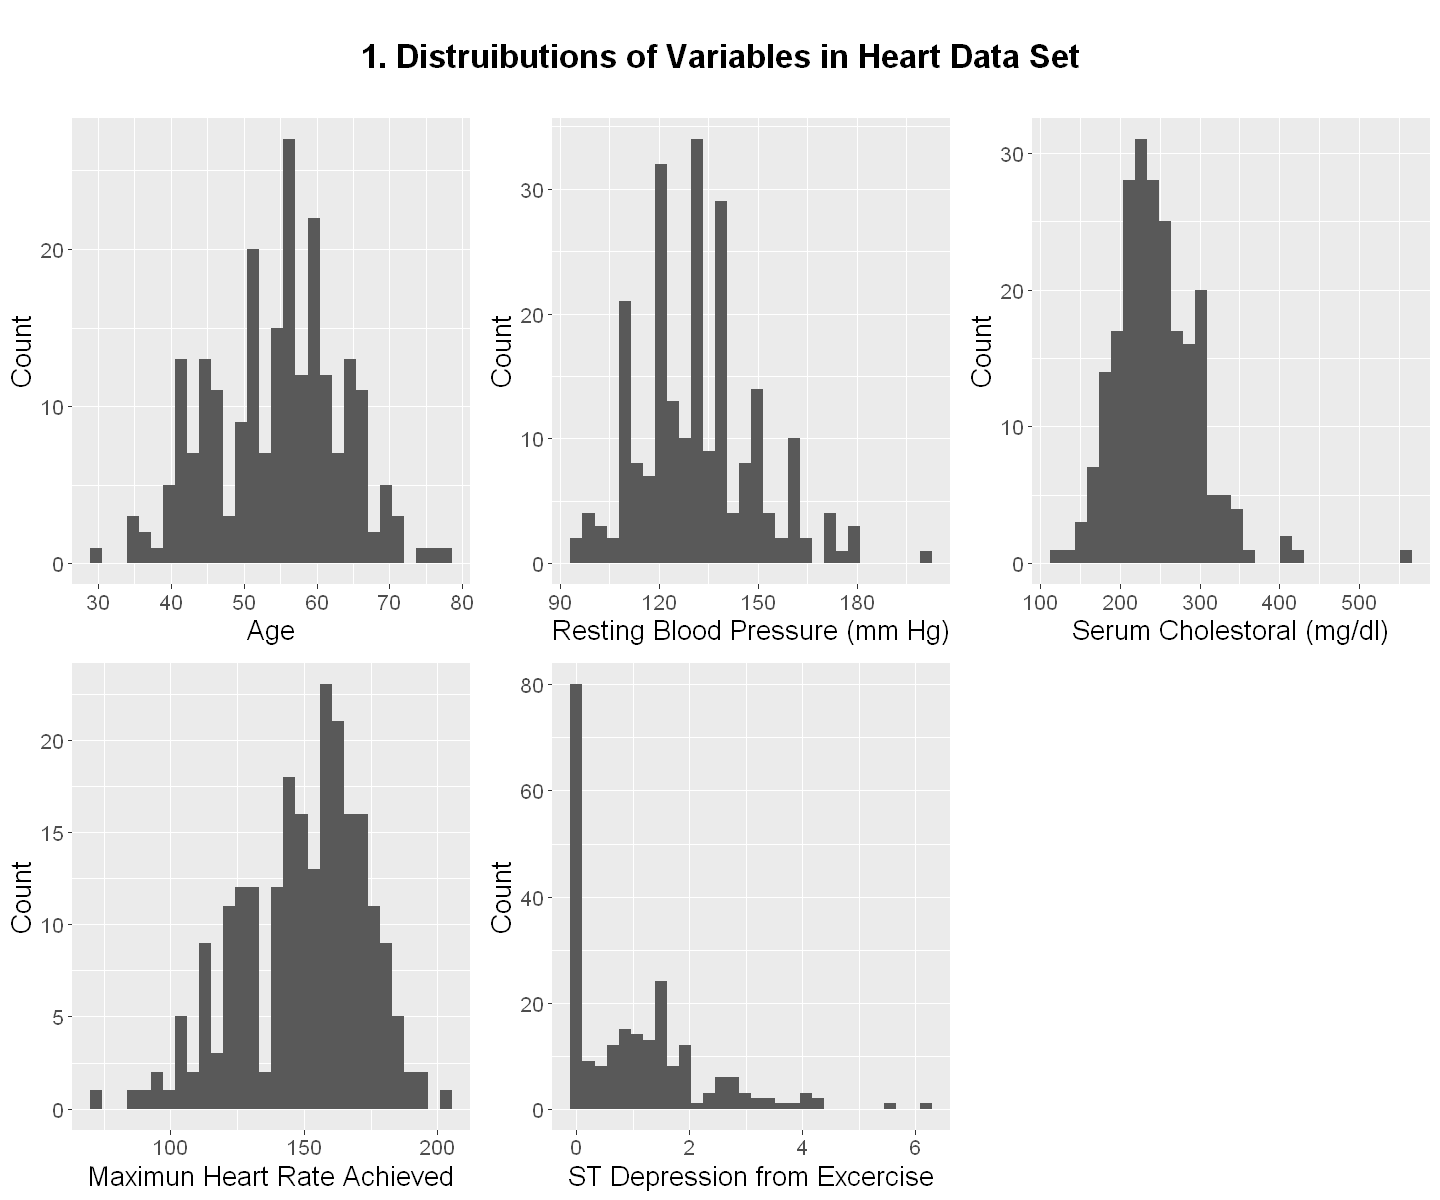

In [6]:
#We use the plot_grid function from the cowplot package to merge all histograms into a single plot as well as add a title.
age_hist <- ggplot(heart_train, aes(x = age)) +
    geom_histogram() +
    labs(x = "Age", y = "Count") +
    theme(text = element_text(size=16))
trestbps_hist <- ggplot(heart_train, aes(x = trestbps)) +
    geom_histogram() +
    labs(x = "Resting Blood Pressure (mm Hg)", y = "Count") +
    theme(text = element_text(size=16)) 
chol_hist <- ggplot(heart_train, aes(x = chol)) +
    geom_histogram() +
    labs(x = "Serum Cholestoral (mg/dl)", y = "Count") +
    theme(text = element_text(size=16))
thalach_hist <- ggplot(heart_train, aes(x = thalach)) +
    geom_histogram() +
    labs(x = "Maximun Heart Rate Achieved", y = "Count") +
    theme(text = element_text(size=16))
oldpeak_hist <- ggplot(heart_train, aes(x = oldpeak)) +
    geom_histogram() +
    labs(x = "ST Depression from Excercise", y = "Count") +
    theme(text = element_text(size=16))
title <- ggdraw() + draw_label("1. Distruibutions of Variables in Heart Data Set", fontface='bold', size = 20)
heart_hist <- plot_grid(age_hist, trestbps_hist, chol_hist, thalach_hist, oldpeak_hist)
heart_hist_title <- plot_grid(title, heart_hist, ncol=1, rel_heights=c(0.1, 1))
heart_hist_title

We use ggplot to make histograms in order to visualize the distribution of each potential predictor. This may be useful for when we decide which predictors to use. 

**Methods**

In order to create a classification model, we first split our data into training and testing sets. Our model will use the k nearest neighbors algorithm. We must first scale and center the training data as the algorithm is affected by the scale of predictors. We will then split the training set into 5 groups to perform cross validation, determining the best value for k. Next, we can use forward selection to calculate the set of predictors with the greatest classification accuracy. Categorical variables often do not make good predictors due to their rough distributions, so we will only consider numerical variables as candidates for potential predictors. Once we have determined our k value and predictors, the next step is to set up a workflow with a recipe and classifier and train the classifier using our training data. Now that the classification model has been created, we will test the accuracy of the model by passing the test data into the model. Our results will be visualized with a confusion matrix alongside scatterplots of the predictor variables. Each observation will include a fill color to illustrate its class. 


**Expected outcomes and significance:**

We expect to establish which variables in the heart disease data set are best suited to be used as predictors for determining the presence of heart disease and the accuracy it can be done with.  

The early prediction of heart disease may help prevent it in many individuals as well as allow for more effective treatment. This would not only save many lives but also serve to ease the financial burden on the healthcare system.  

This analysis could lead to questions of how heart disease can be prevented, including those around identifying additional risk factors. Further extensions could include analysis into how predictors could be identified prior to symptoms arising to prevent impacts of the disease. Additionally, similar frameworks can be applied to other chronic conditions with major burdens on individuals and healthcare systems. 


**Bibliography:**  

Cardiovascular diseases affect nearly half of American adults, statistics show. www.heart.org. (2021, November 23). Retrieved March 9, 2023, from https://www.heart.org/en/news/2019/01/31/cardiovascular-diseases-affect-nearly-half-of-american-adults-statistics-show  

Centers for Disease Control and Prevention. (2022, October 14). Heart disease facts. Centers for Disease Control and Prevention. Retrieved March 9, 2023, from https://www.cdc.gov/heartdisease/facts.htm  
    
 Hungarian Institute of Cardiology. (1988, July 1). Heart Disease Data Set. UCI Machine Learning Repository: Heart disease data set. Retrieved March 9, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease